## Visualize some graphs with matplotlib and networkx

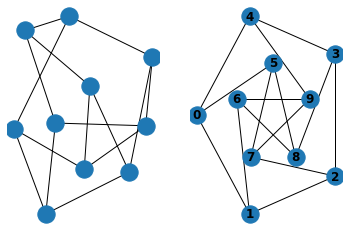

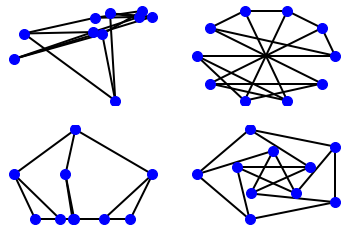

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
G = nx.petersen_graph()
plt.subplot(121)
nx.draw(G, with_labels=False, font_weight='bold')
plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

plt.figure()
options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 2,
}
plt.subplot(221)
nx.draw_random(G, **options)
plt.subplot(222)
nx.draw_circular(G, **options)
plt.subplot(223)
nx.draw_spectral(G, **options)
plt.subplot(224)
nx.draw_shell(G, nlist=[range(5,10), range(5)], **options)



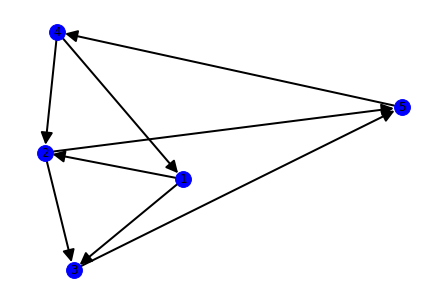

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
options = {
    'node_color': 'blue',
    'node_size': 250,
    'width': 2,
     'arrowstyle': '-|>',
    'arrowsize': 25,
}
g = nx.DiGraph()
g.add_nodes_from([1,2,3,4,5])
g.add_edge(1,2)
g.add_edge(4,2)
g.add_edge(3,5)
g.add_edge(2,3)
g.add_edge(5,4)
g.add_edge(1,3)
g.add_edge(2,5)
g.add_edge(4,1)

nx.draw(g,with_labels=True,**options)
plt.draw()
plt.show()

{(1, 2): Text(1.5, 1.5, '0.5'),
 (1, 3): Text(1.0, 0.5, '9.8'),
 (2, 3): Text(1.5, 1.0, '4')}

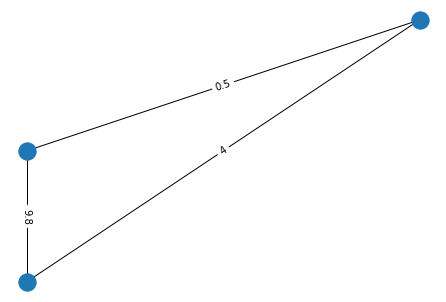

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.Graph()
G.add_node(1,pos=(1,1))
G.add_node(2,pos=(2,2))
G.add_node(3,pos=(1,0))

G.add_edge(1,2,weight=0.5)
G.add_edge(1,3,weight=9.8)
G.add_edge(2,3,weight=4)

pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)


In [ ]:
import numpy as np
import scipy.sparse as sparse
row =  np.array([0, 3, 1, 0])
col =   np.array([0, 3, 1, 2])
data = np.array([4, 5, 7, 9])

mtx = sparse.coo_matrix((data, (row, col)), shape=(4, 4))    
mtx.todense()


matrix([[4, 0, 9, 0],
        [0, 7, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 5]])

# Representing graphs

Let's create a random binary adjcency matrix

In [ ]:
import torch

def create_adj(size):
  a = torch.rand(size,size)
  a[a>0.5] = 1
  a[a<=0.5] = 0

  # for illustration i set the diagonal elemtns to zero
  for i in range(a.shape[0]):
    for j in range(a.shape[1]):
      if i==j:
        a[i,j] = 0
  return a


print(create_adj(5))

tensor([[0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1.],
        [1., 0., 1., 0., 0.]])


In [ ]:
def calc_degree_matrix(a):
  return torch.diag(a.sum(dim=-1))

a = create_adj(5)
d = calc_degree_matrix(a)

print(d)

def create_graph_lapl(a):
  return calc_degree_matrix(a)-a

print(a)
print(create_graph_lapl(a))

def calc_degree_matrix_norm(a):
  return torch.diag(torch.pow(a.sum(dim=-1),-0.5))

def create_graph_lapl_norm(a):
  size = a.shape[-1]
  D_norm = calc_degree_matrix_norm(a)
  L_norm = torch.ones(size) - (D_norm @ a @ D_norm )
  return L_norm


tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 2., 0.],
        [0., 0., 0., 0., 2.]])
tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 1., 0., 1., 0.]])
tensor([[ 1.,  0., -1.,  0.,  0.],
        [ 0.,  1.,  0., -1.,  0.],
        [ 0., -1.,  1.,  0.,  0.],
        [ 0., -1.,  0.,  2., -1.],
        [ 0., -1.,  0., -1.,  2.]])


# Spectral image segmentation with graph laplacian
Tutorial code adapted from https://scipy-lectures.org/advanced/image_processing/auto_examples/plot_spectral_clustering.html

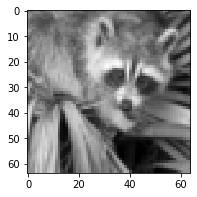

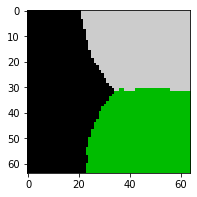

In [ ]:
import numpy as np
from scipy import misc
from skimage.transform import resize
import matplotlib.pyplot as plt 
from numpy import linalg as LA
from scipy.sparse import csgraph
from sklearn.feature_extraction.image import img_to_graph
from sklearn.cluster import spectral_clustering


re_size = 64 # downsampling of resized rectangular image 
img = misc.face(gray=True)  # retrieve a grayscale image
img = resize(img, (re_size, re_size))
mask = img.astype(bool)
graph = img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependant from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())
labels = spectral_clustering(graph, n_clusters=3)
label_im = -np.ones(mask.shape)
label_im[mask] = labels

plt.figure(figsize=(6, 3))
plt.imshow(img, cmap='gray', interpolation='nearest')

plt.figure(figsize=(6, 3))
plt.imshow(label_im, cmap=plt.cm.nipy_spectral, interpolation='nearest')
plt.show()

# Chebyshev approximation for the Laplacian powers

In [ ]:
import torch
import torch.nn as nn
def find_eigmax(L):
    with torch.no_grad():
        e1, _ = torch.eig(L, eigenvectors=False)
        return torch.max(e1[:, 0]).item()

def chebyshev_Lapl(X, Lapl, thetas, order):
  list_powers = []
  nodes = Lapl.shape[0]

  T0 = X.float()

  eigmax = find_eigmax(Lapl)
  L_rescaled = (2 * Lapl / eigmax) - torch.eye(nodes)

  y = T0 * thetas[0]
  list_powers.append(y)
  T1 = torch.matmul(L_rescaled, T0)
  list_powers.append(T1 * thetas[1])

  # Computation of: T_k = 2*L_rescaled*T_k-1  -  T_k-2
  for k in range(2, order):
      T2 = 2 * torch.matmul(L_rescaled, T1) - T0
      list_powers.append((T2 * thetas[k]))
      T0, T1 = T1, T2
  y_out = torch.stack(list_powers, dim=-1)
  # the powers may be summed or concatenated. i use concatenation here
  y_out = y_out.view(nodes, -1) # -1 = order* features_of_signal
  return y_out

features = 3
out_features = 50
a = create_adj(10)
L = create_graph_lapl_norm(a)
x = torch.rand(10, features)
power_order = 4 # p-hops
thetas = nn.Parameter(torch.rand(4))

out = chebyshev_Lapl(x,L,thetas,power_order)

print('cheb approx out powers concatenated:', out.shape)
# because we used concatanation  of the powers
# the out features will be power_order * features
linear = nn.Linear(4*3, out_features) 

layer_out = linear(out)
print('Layers output:', layer_out.shape)


cheb approx out powers concatenated: torch.Size([10, 12])
Layers output: torch.Size([10, 50])


# Custom implementation of a standard GCN

In [ ]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

def device_as(x,y):
  return x.to(y.device)

# tensor operationa now support batched inputs
def calc_degree_matrix_norm(a):
  return torch.diag_embed(torch.pow(a.sum(dim=-1),-0.5))

def create_graph_lapl_norm(a):
  size = a.shape[-1]
  a +=  device_as(torch.eye(size),a)
  D_norm = calc_degree_matrix_norm(a)
  L_norm = torch.bmm( torch.bmm(D_norm, a) , D_norm )
  return L_norm

class GCN_AISUMMER(nn.Module):
    """
    A simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    def __init__(self, in_features, out_features, bias=True):
      super().__init__()
      self.linear = nn.Linear(in_features, out_features, bias=bias)

    def forward(self, X, A):
        """
        A: adjecency matrix
        X: graph signal
        """
        L = create_graph_lapl_norm(A)
        x = self.linear(X)
        return torch.bmm(L, x)

# Download MUTAG dataset and install torchnet

In [ ]:
!wget https://ls11-www.cs.tu-dortmund.de/people/morris/graphkerneldatasets/MUTAG.zip
!unzip MUTAG.zip
!pip install torchnet networkx

# Extra graph utils and data loading stuff

In [ ]:
import torchnet as tnt
import os
import networkx as nx
import numpy as np
import torch

def indices_to_one_hot(number, nb_classes, label_dummy=-1):
    """Convert an iterable of indices to one-hot encoded labels."""
    if number == label_dummy:
        return np.zeros(nb_classes)
    else:
        return np.eye(nb_classes)[number]

def get_graph_signal(nx_graph):
  d = dict((k, v) for k, v in nx_graph.nodes.items())
  x = []
  invd = {}
  j = 0
  for k, v in d.items():
      x.append(v['attr_dict'])
      invd[k] = j
      j = j + 1
  return np.array(x)


def load_data(path, ds_name, use_node_labels=True, max_node_label=10):
    node2graph = {}
    Gs = []
    data = []
    dataset_graph_indicator = f"{ds_name}_graph_indicator.txt"
    dataset_adj = f"{ds_name}_A.txt"
    dataset_node_labels = f"{ds_name}_node_labels.txt"
    dataset_graph_labels = f"{ds_name}_graph_labels.txt"

    path_graph_indicator = os.path.join(path,dataset_graph_indicator)
    path_adj = os.path.join(path,dataset_adj)
    path_node_lab = os.path.join(path,dataset_node_labels)
    path_labels = os.path.join(path,dataset_graph_labels)


    with open(path_graph_indicator, "r") as f:
        c = 1
        for line in f:
            node2graph[c] = int(line[:-1])
            if not node2graph[c] == len(Gs):
                Gs.append(nx.Graph())
            Gs[-1].add_node(c)
            c += 1

    with open(path_adj, "r") as f:
        for line in f:
            edge = line[:-1].split(",")
            edge[1] = edge[1].replace(" ", "")
            Gs[node2graph[int(edge[0])] - 1].add_edge(int(edge[0]), int(edge[1]))

    if use_node_labels:
      with open(path_node_lab, "r") as f:
        c = 1
        for line in f:
          node_label = indices_to_one_hot(int(line[:-1]), max_node_label)
          Gs[node2graph[c] - 1].add_node(c, attr_dict=node_label)
          c += 1

    labels = []
    with open(path_labels, "r") as f:
        for line in f:
            labels.append(int(line[:-1]))

    return list(zip(Gs, labels)) 

def create_loaders(dataset, batch_size, split_id, offset=-1):
    train_dataset = dataset[:split_id]
    val_dataset = dataset[split_id:]
    return to_pytorch_dataset(train_dataset, offset,batch_size), to_pytorch_dataset(val_dataset, offset,batch_size)

def to_pytorch_dataset(dataset, label_offset=0, batch_size=1):
  list_set = []
  for graph, label in dataset:
    F, G = get_graph_signal(graph), nx.to_numpy_matrix(graph)
    numOfNodes = G.shape[0]
    F_tensor = torch.from_numpy(F).float()
    G_tensor = torch.from_numpy(G).float()

    # fix labels to zero-indexing
    if label == -1:
      label = 0
    
    label += label_offset
    
    list_set.append(tuple((F_tensor, G_tensor, label)))

  dataset_tnt = tnt.dataset.ListDataset(list_set)
  data_loader = torch.utils.data.DataLoader(dataset_tnt, shuffle=True, batch_size=batch_size)
  return data_loader



dataset = load_data(path='./MUTAG/', ds_name='MUTAG',
                  use_node_labels=True, max_node_label=7)
train_dataset, val_dataset = create_loaders(dataset, batch_size=1, split_id=150, offset=0)
print('Data are ready')

Data are ready


# Our final GNN model with graph convolutional units

In [ ]:
import torch
import torch.nn as nn

class GNN(nn.Module):
  def __init__(self,
                    in_features = 7,
                    hidden_dim = 64,
                    classes = 2,
                    dropout = 0.5):
    super(GNN, self).__init__()

    self.conv1 = GCN_AISUMMER(in_features, hidden_dim)
    self.conv2 = GCN_AISUMMER(hidden_dim, hidden_dim)
    self.conv3 = GCN_AISUMMER(hidden_dim, hidden_dim)
    self.fc = nn.Linear(hidden_dim, classes)
    self.dropout = dropout

  def forward(self, x,A):
    x = self.conv1(x, A)
    x = F.relu(x)
    x = self.conv2(x, A)
    x = F.relu(x)
    x = self.conv3(x, A)
    x = F.dropout(x, p=self.dropout, training=self.training)
    # aggregate node embeddings
    x = x.mean(dim=1)
    # final classification layer
    return self.fc(x)



# Train loop

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Training on {device}')
model = GNN(in_features = 7,
                hidden_dim = 128,
                classes = 2).to(device)

optimizer= torch.optim.SGD(model.parameters(), lr=0.01)

def train(train_loader):
    model.train()

    for data in train_loader: 
      optimizer.zero_grad()  
      X, A, labels = data
      X, A, labels = X.to(device), A.to(device), labels.to(device)  
      # Forward pass.
      out = model(X, A)  
      # Compute the graph classification loss.
      loss = criterion(out, labels) 
      # Calculate gradients.
      loss.backward()  
      # Updates the models parameters
      optimizer.step() 

def test(loader):
  model.eval()
  correct = 0
  for data in loader:
    X,A, labels = data
    X,A, labels = X.cuda(), A.cuda(), labels.cuda()  
    # Forward pass.
    out = model(X, A)  
    # Take the index of the class with the highest probability.
    pred = out.argmax(dim=1) 
    # Compare with ground-truth labels.
    correct += int((pred == labels).sum()) 
  return correct / len(loader.dataset)  


# main code :)

best_val = -1
for epoch in range(1, 241):
    train(train_dataset)
    train_acc = test(train_dataset)
    val_acc = test(val_dataset)
    if val_acc>best_val:
      best_val = val_acc
      epoch_best = epoch
    
    if epoch%10==0:
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f} || Best Val Score: {best_val:.4f} (Epoch {epoch_best:03d}) ')

Training on cuda
Epoch: 010, Train Acc: 0.6600, Val Acc: 0.6842 || Best Val Score: 0.6842 (Epoch 001) 
Epoch: 020, Train Acc: 0.6600, Val Acc: 0.6842 || Best Val Score: 0.6842 (Epoch 001) 
Epoch: 030, Train Acc: 0.6800, Val Acc: 0.7105 || Best Val Score: 0.7895 (Epoch 027) 
Epoch: 040, Train Acc: 0.7467, Val Acc: 0.6579 || Best Val Score: 0.7895 (Epoch 027) 
Epoch: 050, Train Acc: 0.7400, Val Acc: 0.6579 || Best Val Score: 0.7895 (Epoch 027) 
Epoch: 060, Train Acc: 0.7200, Val Acc: 0.6842 || Best Val Score: 0.7895 (Epoch 027) 
Epoch: 070, Train Acc: 0.7667, Val Acc: 0.7105 || Best Val Score: 0.7895 (Epoch 027) 
Epoch: 080, Train Acc: 0.7600, Val Acc: 0.7105 || Best Val Score: 0.7895 (Epoch 027) 
Epoch: 090, Train Acc: 0.7600, Val Acc: 0.7105 || Best Val Score: 0.7895 (Epoch 027) 
Epoch: 100, Train Acc: 0.7533, Val Acc: 0.6842 || Best Val Score: 0.7895 (Epoch 027) 
Epoch: 110, Train Acc: 0.7533, Val Acc: 0.6842 || Best Val Score: 0.7895 (Epoch 027) 
Epoch: 120, Train Acc: 0.7800, Val Ac